## Libraries

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from window_ops.expanding import expanding_mean

from typing import List
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# import warnings
# warnings.simplefilter(action='ignore', category=[FutureWarning])

In [3]:
from numba import njit
from window_ops.rolling import rolling_mean
@njit
def rolling_mean_size(x, window_size):
    return rolling_mean(x, window_size)

## Function

In [4]:
def load_data(file_path: str) -> pd.DataFrame:
    '''
    Load data from a CSV file, preprocess it, and return the DataFrame.

    Args:
        file_path (str):
            The path of the CSV file to be loaded. The file should be located in the './Data/' directory.

    Returns:
        pd.DataFrame:
            The DataFrame containing the loaded data after preprocessing.
    '''
    try:
        # Load the data from the CSV file
        df = pd.read_csv(file_path, header=0)
        print('✔️ Dataset Imported Successfully!\n')
        print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

        # Fill missing values with 0
        df.fillna(0, inplace=True)

        # Convert the 'ds' column to datetime type
        df['ds'] = pd.to_datetime(df['ds'])

        return df

    except FileNotFoundError:
        print("❌ Error: The file '{}' does not exist in the './Data/' directory.".format(file_name))
        return pd.DataFrame()  # Return an empty DataFrame in case of file not found error


In [5]:
def filter_by_pattern(df, pattern):
    '''
    Filter the DataFrame based on a specific pattern in the 'unique_id' column.

    Args:
        df (pd.DataFrame):
            The DataFrame to be filtered.
        
        pattern (str):
            The regular expression pattern used for filtering.

    Returns:
        pd.DataFrame:
            The filtered DataFrame containing only rows whose 'unique_id' column matches the specified pattern.
    '''

    # Filter the DataFrame based on the pattern
    df = df[df['unique_id'].str.endswith(pattern)]

    return df

In [6]:
def filter_short_series(df: pd.DataFrame, series_length_threshold: int = 7) -> pd.DataFrame:
    '''
    Filter out rows corresponding to time series with a length shorter than a specified threshold.

    Args:
        df (pd.DataFrame):
            The DataFrame containing the time series data.
        
        series_length_threshold (int):
            The minimum length threshold for a valid time series. Time series with a length
            less than or equal to this threshold will be filtered out.

    Returns:
        pd.DataFrame:
            The DataFrame with rows corresponding to short time series removed.
    '''
    # Group the DataFrame by 'unique_id' and calculate the length of each series
    specific_series_lengths = df.groupby('unique_id')['ds'].count()

    # Get the unique IDs with series length less than the threshold
    short_series_ids = specific_series_lengths[specific_series_lengths <= series_length_threshold].index

    # Filter out the rows corresponding to the short series IDs
    df = df[~df['unique_id'].isin(short_series_ids)]

    return df


### train_test_split

In [7]:
def train_test_split(df: pd.DataFrame, test_num: int=1) -> tuple:
    '''
    Split data for each unique ID in a DataFrame into training and testing sets.

    Args:
        df (pd.DataFrame):
            The DataFrame containing the data to be split.
        
        test_num (int):
            The number of rows to use for testing data for each unique ID.

    Returns:
        tuple:
            A tuple containing two DataFrames:
            - The concatenated DataFrame of the training sets.
            - The concatenated DataFrame of the testing sets.
    '''
    # Initialize empty lists to store training and testing data
    train_data_list = []
    test_data_list = []
    
    unique_ids = df['unique_id'].unique()

    # Split data for each unique ID
    for uid in unique_ids:
        # Create a copy of the DataFrame for the current unique ID
        df_subset = df[df['unique_id'] == uid].copy()
        
        # Extract the training data from the remaining part of the DataFrame
        df_train = df_subset.iloc[:-test_num]
        
        # Extract the testing data from the tail of the DataFrame
        df_test = df_subset.iloc[-test_num:]
        
        # Store the training data and testing data for this ID in the respective lists
        train_data_list.append(df_train)
        test_data_list.append(df_test)

    # Concatenate all training DataFrames into a single DataFrame
    train_df = pd.concat(train_data_list, ignore_index=True)

    # Concatenate all testing DataFrames into a single DataFrame
    test_df = pd.concat(test_data_list, ignore_index=True)

    # Print the information about the original DataFrame, training set, and testing set
    print('Dataset: {} rows, {} columns'.format(df.shape[0], df.shape[1]))
    print('Train set: {} rows, {} columns'.format(train_df.shape[0], train_df.shape[1]))
    print('Test set: {} rows, {} columns'.format(test_df.shape[0], test_df.shape[1]))

    # Return the concatenated training and testing DataFrames as a tuple
    return train_df, test_df

### mlforecast_fit

In [8]:
def mlforecast_fit(train_df: pd.DataFrame, lags: List[int], freq) -> MLForecast:
    '''
    Train a multi-model time series forecasting model using the MLForecast class.

    Args:
        train_df (pd.DataFrame):
            The DataFrame containing the training data for time series forecasting.

        lags (list[int]):
            A list of integers representing the lags to be used for lag transformations.
        
        freq (int or str)

    Returns:
        MLForecast:
            The trained MLForecast object that can be used for forecasting.
    '''
    # Initialize the MLForecast with the specified models, lags, and frequency
    mlf = MLForecast(
        models=[LinearRegression(), RandomForestRegressor(random_state=0), lgb.LGBMRegressor(), xgb.XGBRegressor()],
        lags=lags,
        lag_transforms={1: [expanding_mean]},  # Apply 'expanding_mean' lag transformation to lag 1
        freq = freq  
    )
    
    # Fit the MLForecast model to the training data
    mlf.fit(train_df)

    return mlf

### mlforecast_predict

In [9]:
def mlforecast_predict(test_df: pd.DataFrame, predict_series_length: int) -> pd.DataFrame:
    '''
    Perform predictions using the trained MLForecast model and merge the prediction data with the true values.

    Args:
        test_df (pd.DataFrame):
            The DataFrame containing the true values for testing data.

        predict_series_length (int):
            The number of steps to predict into the future.

    Returns:
        pd.DataFrame:
            The merged DataFrame containing the predictions and true values based on 'unique_id' and 'ds'.
    '''
    # Perform predictions using the trained MLForecast model for 'predict_series_length' steps
    pred_df = mlf.predict(predict_series_length)
    
    # Merge the prediction data with the true values based on 'unique_id' and 'ds'
    pred_df = pred_df.merge(test_df, on=['unique_id', 'ds'])
#     pred_df = pred_df.merge(test_df, on=['unique_id'])
    
    return pred_df

### evaluation

In [10]:
def evaluation(pred_df: pd.DataFrame, category, output_file_path: str):
    '''
    Evaluate the performance of predictions made by multiple models using MSE, MAE, and MAPE, and save the results to an Excel file.

    Args:
        pred_df (pd.DataFrame):
            The DataFrame containing predictions made by multiple models.

        output_file (str):
            The file path where the evaluation results will be saved.

    Returns:
        None
    '''
    # Get the names of the models used for prediction from the DataFrame
#     models = ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor',
#        'XGBRegressor']
#     models = ['LGBMRegressor',
#         'XGBRegressor']
    models = list(pred_df.columns[2:-1])
    output_data = [category]
    for model in models:
        # Extract true values and predicted values from the DataFrame for the current model
        true_values = pred_df['y']
        predicted_values = pred_df[model]

        # Calculate Root Mean Squared Error (MSE)
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(true_values, predicted_values)

        # Calculate Mean Absolute Percentage Error (MAPE)
        ape = np.abs((true_values - predicted_values) / true_values).replace([np.inf, -np.inf], 0)
        mape = np.mean(ape)

        performance = '{:.2f}/{:.2f}/{:.2f}'.format(rmse,mae,mape)
        output_data.append(performance)
    
    evaluation_df = pd.DataFrame([output_data], columns=['Category'] + models)
    
    # Check if the output file exists
    file_exists = os.path.isfile(output_file_path)
    # Save the evaluation results to an Excel file
    evaluation_df.to_csv(output_file_path, index=False, encoding='utf-8-sig', mode='a+', header=not file_exists)
    print(f'✔️ {category} Saved Successfully!\n')

In [11]:
def plot_unique_id(df):
    unique_ids = df['unique_id'].unique()
    selected_ids = np.random.choice(unique_ids, size=len(unique_ids), replace=False)

    # Calculate the number of rows and columns for the subplot grid
    num_subplots = len(selected_ids)
    num_columns = 4
    num_rows = (num_subplots - 1) // num_columns + 1  # Calculate the number of rows

    # Create subplots for each unique_id
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3*num_rows))

    # Plot each subset of data in the corresponding subplot
    for i, uid in enumerate(selected_ids):
        df_subset = df[df['unique_id'] == uid].copy()
        # Round 'y' to 2 decimal places
        df_subset['ds'] = pd.to_datetime(df_subset['ds'])

        # Calculate the row and column index for the current subplot
        row_index = i // num_columns
        col_index = i % num_columns

        # Select the corresponding subplot
        ax = axes[row_index, col_index]

        df_subset.plot(x='ds', y='y', ax=ax, title=f'Unique ID: {uid}')

    # If there are empty subplots, remove the axes
    for i in range(num_subplots, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])
    
    plt.rcParams['font.sans-serif'] = ['SimSun']
    plt.rcParams['axes.unicode_minus'] = False
    plt.tight_layout()
    plt.show()

In [12]:
def rank_acf_pacf(series: pd.Series, lags: int) -> tuple:
    '''
    Calculate autocorrelation and partial autocorrelation values for a given series and number of lags.

    Args:
        series (pd.Series):
            The time series data for which autocorrelation and partial autocorrelation will be calculated.

        lags (int):
            The number of lags to consider for autocorrelation calculations.

    Returns:
        tuple:
            A tuple containing two dictionaries:
            - A dictionary containing lag-indexed autocorrelation values sorted in descending order.
            - A dictionary containing lag-indexed partial autocorrelation values sorted in descending order.
            
    Example:
        acf_dict, pacf_dict = rank_acf_pacf(my_series, 90)
    '''

    # Calculate autocorrelation values
    acf_values = acf(series, nlags=lags)
    acf_dict = {}
    for lag, val in enumerate(np.abs(acf_values)):
        acf_dict[lag] = val
    acf_sorted = dict(sorted(acf_dict.items(), key=lambda item: item[1], reverse=True))

    # Calculate partial autocorrelation values
    pacf_values = pacf(series, nlags=lags)
    pacf_dict = {}
    for lag, val in enumerate(np.abs(pacf_values)):
        pacf_dict[lag] = val
    pacf_sorted = dict(sorted(pacf_dict.items(), key=lambda item: item[1], reverse=True))

    return acf_sorted, pacf_sorted


## Pipeline

In [13]:
data_path = './Data/'

In [77]:
# file_names = ['month_Top-50.csv']
# df = load_data(data_path+file_name)
# #     categories = df['unique_id'].str.split(' ').str[1].unique()
# categories = df['unique_id'].unique()
# all_pred_df = pd.DataFrame()
# for category in categories:
#     print('Category:',category)
#     temp_df = filter_by_pattern(df, category)
#     temp_df = filter_short_series(temp_df,7)
#     train_df, test_df = train_test_split(temp_df)
#     mlf = mlforecast_fit(train_df,[1,2,3], 'MS')
#     # Save the model
#     filename = f'./model_pkl/{category}.pkl'
# #         with open(filename, 'wb') as file:
# #             pickle.dump(mlf, file)
#     pred_df = mlforecast_predict(test_df,1)
#     all_pred_df = pd.concat([all_pred_df, pred_df])
#     evaluation(pred_df, category, './Evaluation/'+file_name)
# evaluation(all_pred_df, 'Average', './Evaluation/'+file_name)

✔️ Dataset Imported Successfully!

It contains 17529 rows and 3 columns.
Category: C008:871734
Dataset: 358 rows, 3 columns
Train set: 357 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 354, number of used features: 4
[LightGBM] [Info] Start training from score 7.144068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [24]:
# all_pred_df = pd.DataFrame()
# for category in categories:
#     print('Category:',category)

#     temp_df = df[df['unique_id'] == category]

#     # Calculate the rank for each group of 'unique_id' based on 'ds' and replace it
#     temp_df['ds'] = temp_df['ds'].rank().astype('int64')

#     train_df, test_df = train_test_split(temp_df, 1)
    
#     acf_sorted, pacf_sorted = rank_acf_pacf(temp_df['y'], 5)
#     lags_ls = list(pacf_sorted.keys())[0:5]
#     window_size = min(max(list(acf_sorted.keys())[0:5]),4)
    
#     # Initialize the MLForecast with the specified models, lags, and frequency
#     mlf = MLForecast(
#     models=[lgb.LGBMRegressor(), xgb.XGBRegressor()],
#     lags=lags_ls,
#     lag_transforms={
#         1: [expanding_mean],
#         1: [(rolling_mean, window_size)]
#     },
#     freq = 1  
#     )

#     # Fit the MLForecast model to the training data
#     mlf.fit(train_df)
#     # Save the model
# #     filename = f'./model_pkl/{category}.pkl'
# #     with open(filename, 'wb') as file:
# #         pickle.dump(mlf, file)
#     pred_df = mlforecast_predict(test_df, 1)
#     all_pred_df = pd.concat([all_pred_df, pred_df])
#     evaluation(pred_df, category+f'{lags_ls}', './Evaluation/'+file_name)
# evaluation(all_pred_df, 'Average', './Evaluation/'+file_name)

Category: A003:228644
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 642.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ A003:566768[0, 1, 2, 4, 3] Saved Successfully!

Category: A003:683601
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7, number of used features: 0
[LightGBM] [Info] Start training from score 97.428571
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped train

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ A003:822389[0, 5, 2, 4, 3] Saved Successfully!

Category: A003:871734
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 151.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 959.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 133.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[L

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ C001:205516[0, 2, 4, 1, 5] Saved Successfully!

Category: C008:228644
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 519.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ C008:784457[0, 1, 2, 4, 5] Saved Successfully!

Category: C008:822389
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 642.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ C008:849886[0, 4, 1, 3, 2] Saved Successfully!

Category: C008:871734
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 186.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ C008:890285[0, 3, 1, 4, 5] Saved Successfully!

Category: C009:228644
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 874.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

✔️ C010:205516[0, 1, 3, 5, 4] Saved Successfully!

Category: D005:228644
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 1101.166667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped tra

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7, number of used features: 0
[LightGBM] [Info] Start training from score 595.428571
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

✔️ G005:871734[0, 4, 1, 2, 5] Saved Successfully!

Category: G005:890285
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 675.833333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7, number of used features: 0
[LightGBM] [Info] Start training from score 1052.857143
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

✔️ J011:205516[0, 5, 1, 3, 4] Saved Successfully!

Category: J012:205516
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 632.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 615.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 826.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 703.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

✔️ N001:871734[0, 1, 4, 5, 2] Saved Successfully!

Category: N003:228644
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 571.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ N003:822389[0, 5, 4, 1, 3] Saved Successfully!

Category: N003:871734
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 106.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


✔️ N010:228644[0, 5, 4, 1, 3] Saved Successfully!

Category: N011:205516
Dataset: 12 rows, 3 columns
Train set: 11 rows, 3 columns
Test set: 1 rows, 3 columns
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 947.333333
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 681.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')
C:\Users\user\AppData\Local\Temp\ipykernel_24452\3891235782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 6, number of used features: 0
[LightGBM] [Info] Start training from score 809.666667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

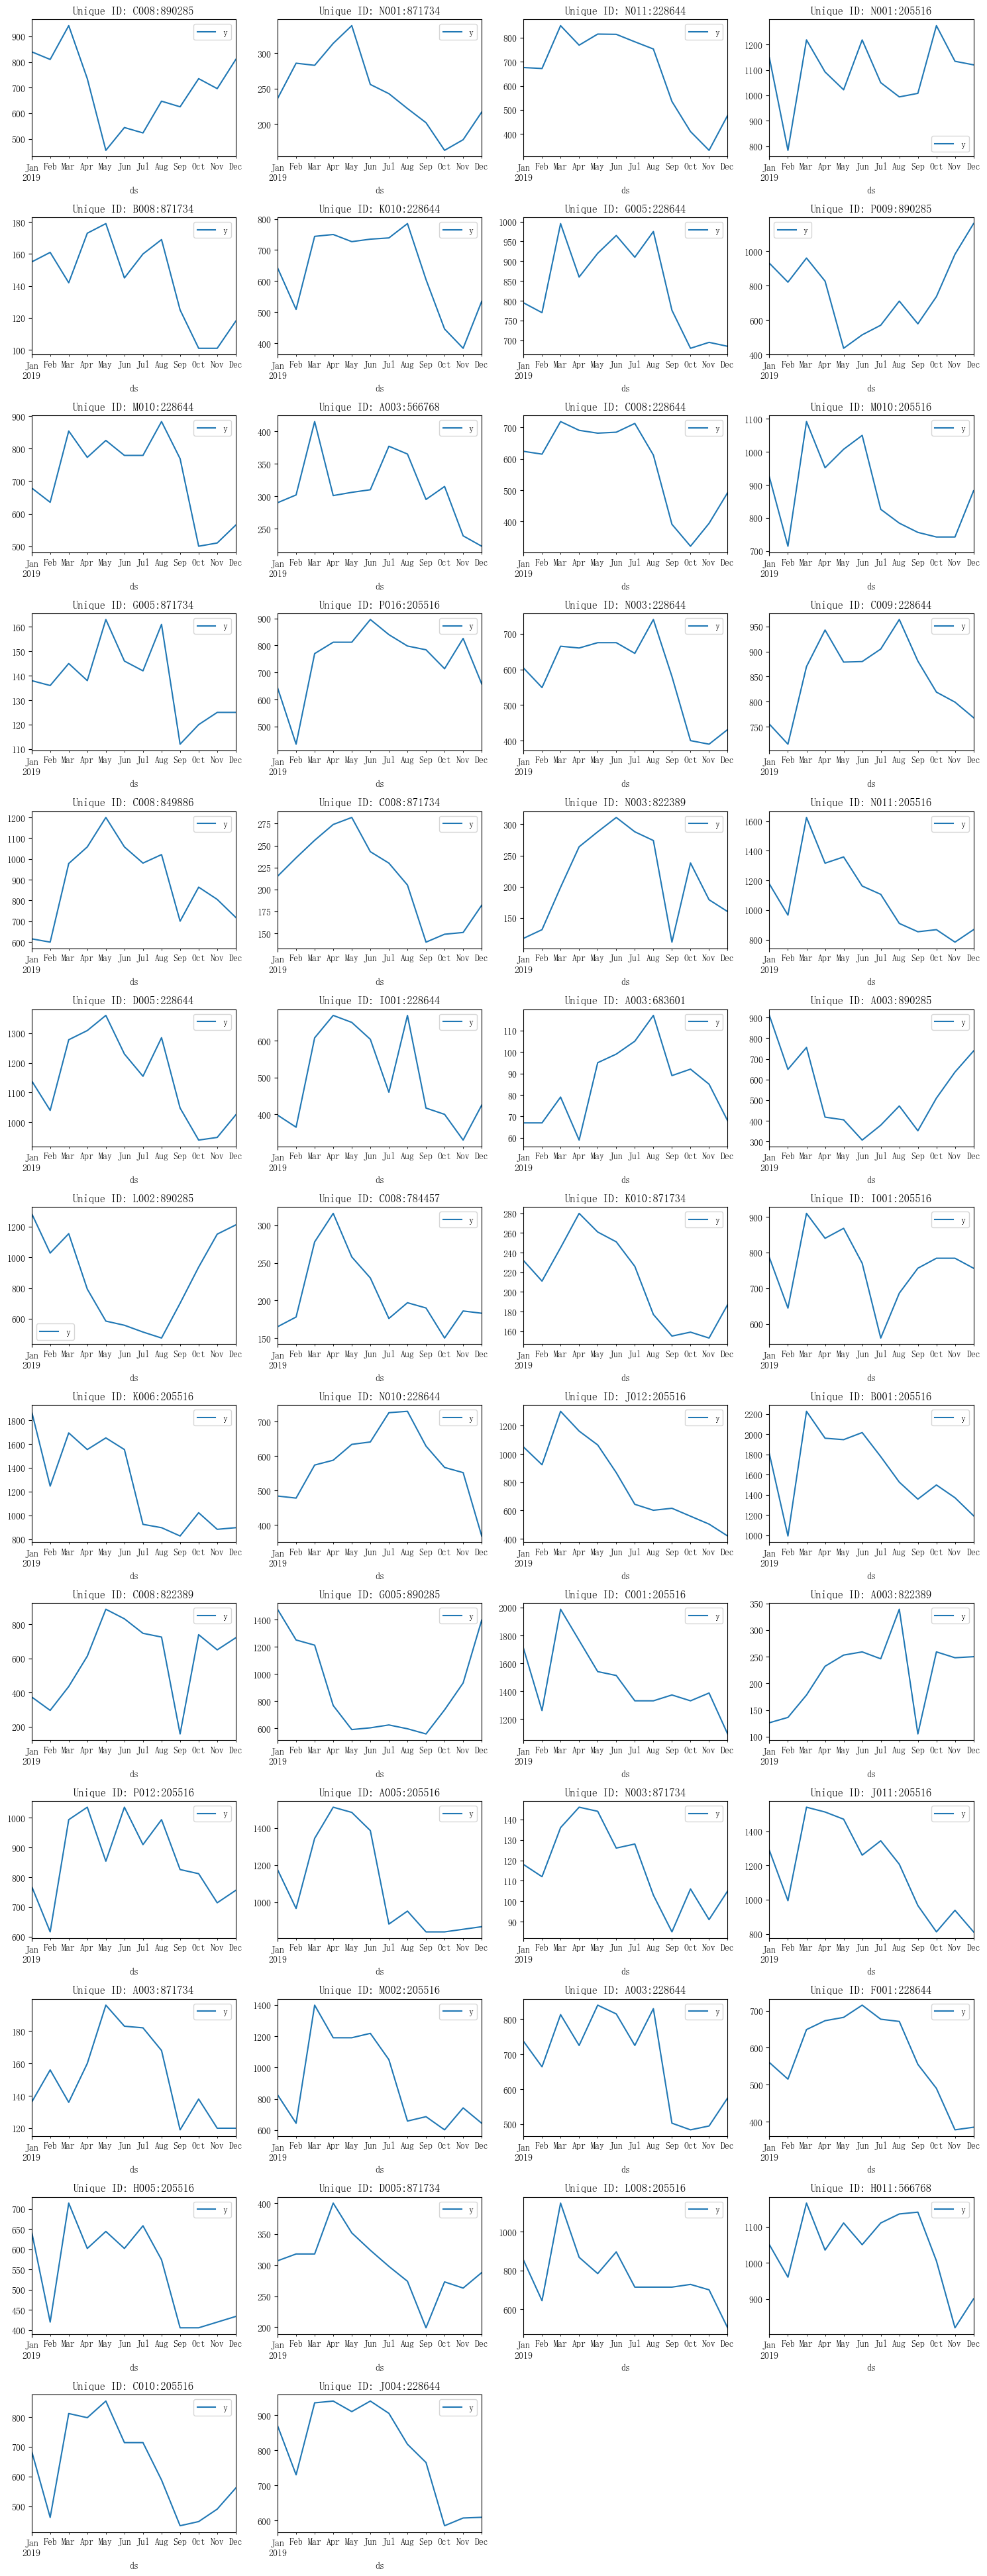

In [40]:
plot_unique_id(df)

In [31]:
# data_path = './Data/'
# file_names = ['supplement.csv']
# # file_names = ['alcohol.csv', 'supplement&drink.csv', 'supplement.csv']
# for file_name in file_names:
#     df = load_data(data_path+file_name)
#     categories = df['unique_id'].str.split(' ').str[1].unique()
#     categories = categories[categories!='保健食品33']
#     all_pred_df = pd.DataFrame()
#     for category in categories:
#         print('Category:',category)
        
#         temp_df = filter_by_pattern(df, category)
#         temp_df = filter_short_series(temp_df,13)
        
#         # Calculate the rank for each group of 'unique_id' based on 'ds' and replace it
#         temp_df['ds'] = temp_df.groupby('unique_id')['ds'].rank().astype('int64')
        
#         train_df, test_df = train_test_split(temp_df)
#         mlf = mlforecast_fit(train_df,[1,2,3,12], 1)
#         # Save the model
#         filename = f'./model_pkl/{category}.pkl'
#         with open(filename, 'wb') as file:
#             pickle.dump(mlf, file)
#         pred_df = mlforecast_predict(test_df,1)
#         all_pred_df = pd.concat([all_pred_df, pred_df])
# #         evaluation(pred_df, category, './Evaluation/'+file_name)
# # evaluation(all_pred_df, 'Average', './Evaluation/'+file_name)

## Top-50.csv

In [14]:
file_name = 'Top-50.csv'
df = load_data(data_path+file_name)
categories = df['unique_id'].unique()

✔️ Dataset Imported Successfully!

It contains 17529 rows and 3 columns.


In [28]:
categories

array(['C008:871734', 'A003:228644', 'C008:822389', 'A003:822389',
       'A003:890285', 'C008:890285', 'N003:228644', 'D005:871734',
       'K006:205516', 'A005:205516', 'L002:890285', 'G005:871734',
       'C008:228644', 'M010:205516', 'B001:205516', 'P009:890285',
       'G005:890285', 'N011:205516', 'G005:228644', 'A003:683601',
       'D005:228644', 'A003:871734', 'N003:871734', 'C008:849886',
       'J012:205516', 'H011:566768', 'A003:566768', 'J011:205516',
       'N011:228644', 'N003:822389', 'B008:871734', 'C010:205516',
       'P016:205516', 'P012:205516', 'J004:228644', 'H005:205516',
       'K010:228644', 'K010:871734', 'C008:784457', 'N001:205516',
       'L008:205516', 'N001:871734', 'N010:228644', 'I001:205516',
       'F001:228644', 'M010:228644', 'I001:228644', 'C001:205516',
       'M002:205516', 'C009:228644'], dtype=object)

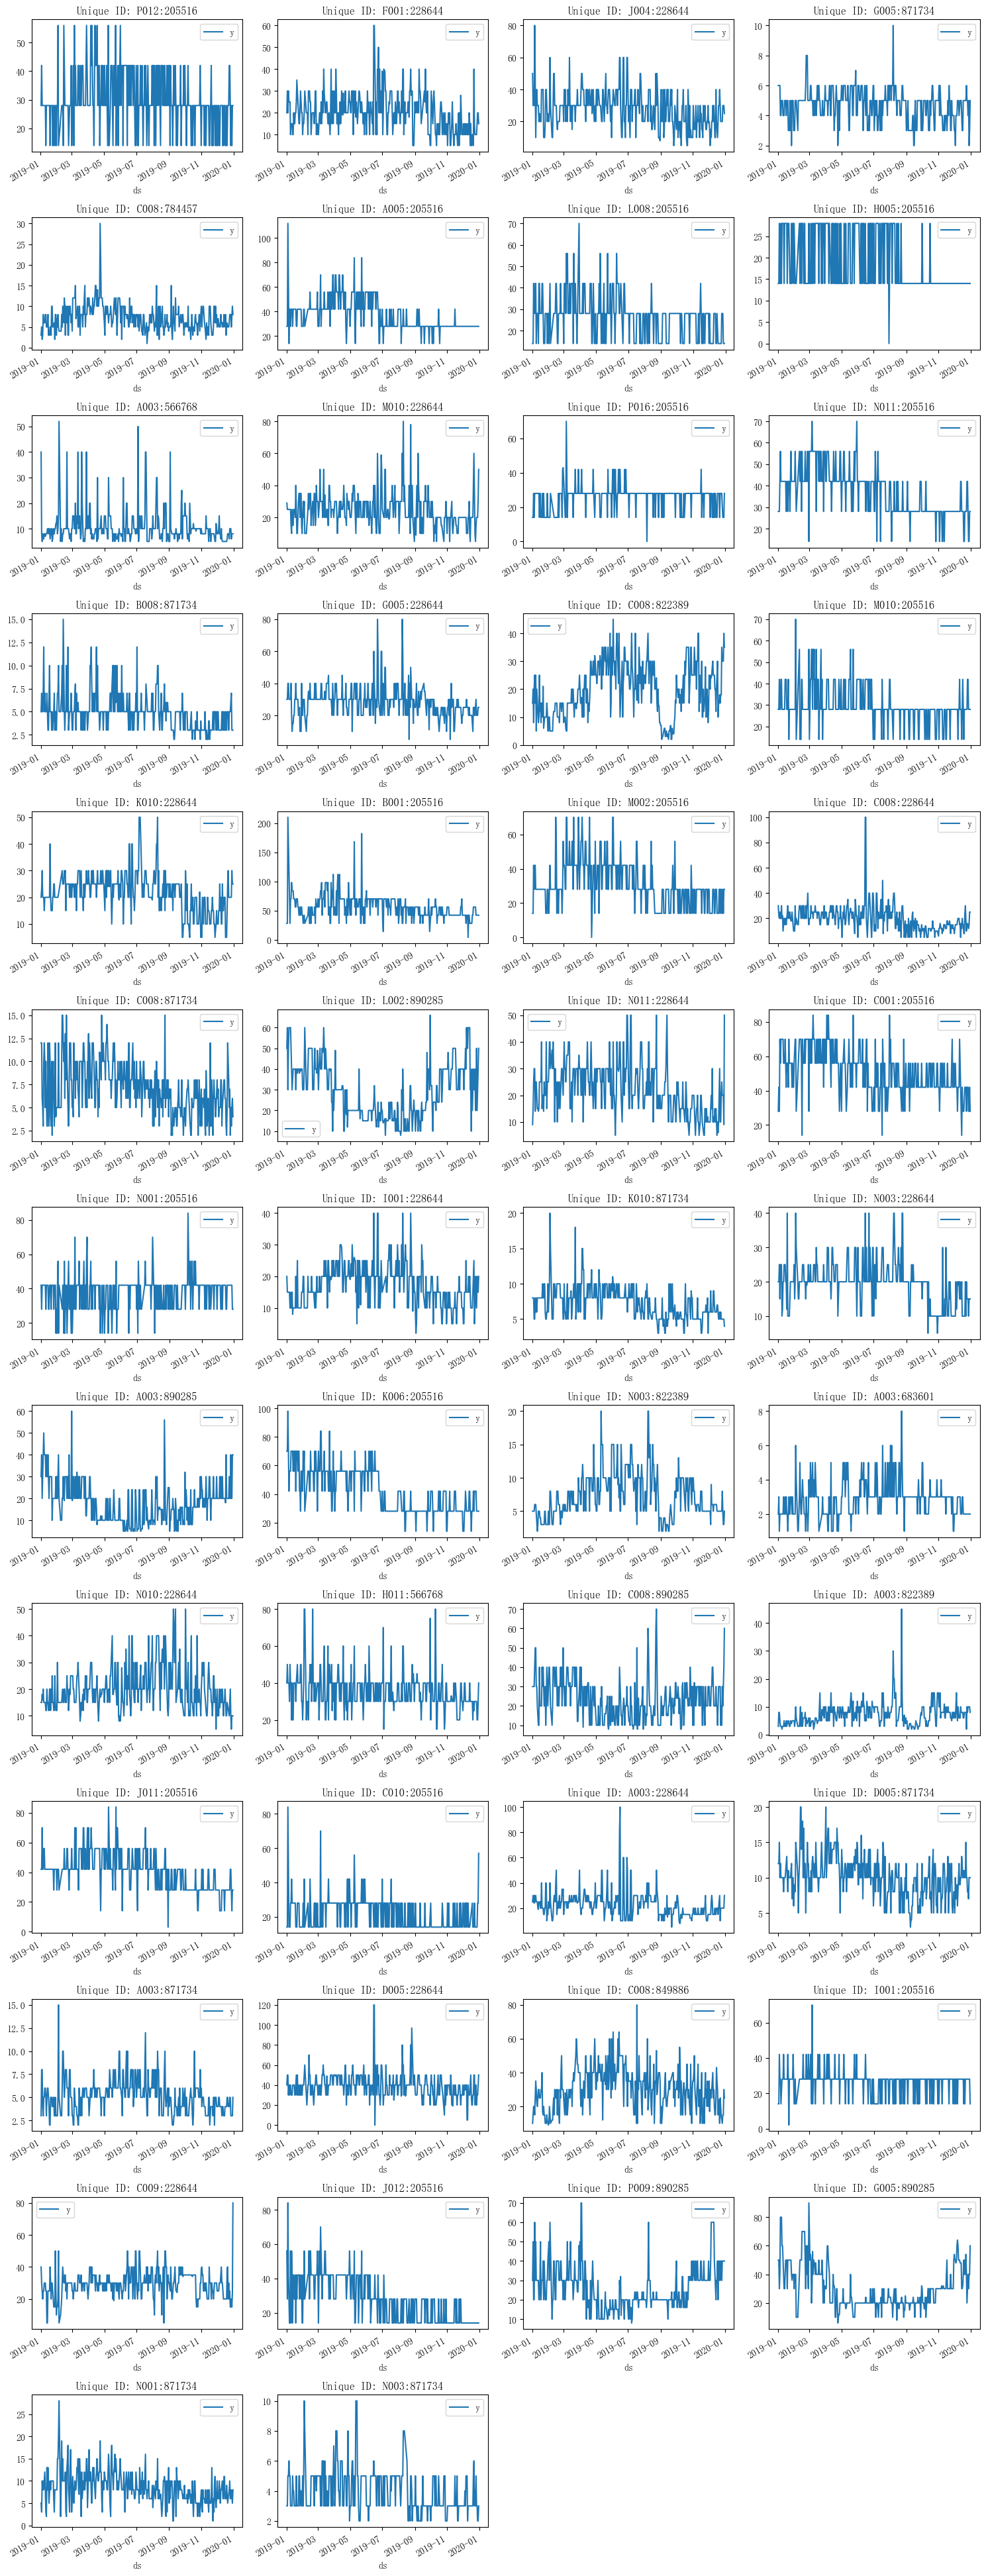

In [15]:
plot_unique_id(df)

In [39]:
all_pred_df = pd.DataFrame()
for category in categories:
    print('Category:',category)
    temp_df = df[df['unique_id'] == category]

    # Calculate the rank for each group of 'unique_id' based on 'ds' and replace it
    temp_df['ds'] = temp_df['ds'].rank().astype('int64')

    train_df, test_df = train_test_split(temp_df, 3)
    
    acf_sorted, pacf_sorted = rank_acf_pacf(temp_df['y'], 90)
    lags_ls = [1,2,3]
    pacf_lag = list(pacf_sorted.keys())
    pacf_lag.remove(0)
    for lag in lags_ls:
        pacf_lag.remove(lag)
#     lags_ls += pacf_lag[0:3]
    window_size = min(max(list(acf_sorted.keys())[0:5]),30)
    
    # Initialize the MLForecast with the specified models, lags, and frequency
#     mlf = mlforecast_fit(train_df,lags_ls, 1)
#     mlf = MLForecast(
#     models=[linear_model.Lasso(alpha=0.25), 
#             RandomForestRegressor(random_state=0, max_depth = 6), # max_leaf_nodes = 10
#             lgb.LGBMRegressor(reg_alpha=0.25, max_depth=4, learning_rate=0.1, num_leaves=2), # num_leaves (int, optional (default=31)) – Maximum tree leaves for base learners.
#             xgb.XGBRegressor(reg_alpha=0.5, max_depth=6, learning_rate=0.1)], # max_leaves = 10
#     lags=lags_ls,
#     lag_transforms={
#         1: [expanding_mean], 
#         1: [(rolling_mean, window_size)],
#         1: [(rolling_mean, 5)],
#         1: [(rolling_mean, 10)]
#     },
#     freq = 1  
#     )
    mlf = MLForecast(
    models=[LinearRegression(),
            Lasso(alpha = 0.25),
            RandomForestRegressor(random_state=0, max_depth = 3), # max_leaf_nodes = 10
            lgb.LGBMRegressor(reg_alpha=0.25, max_depth=3, learning_rate=0.1, num_leaves=2)], # num_leaves (int, optional (default=31)) – Maximum tree leaves for base learners.
    lags=[1,2,3],
    lag_transforms={
        1: [(rolling_mean, 30)],},
    freq = 1  
    )

    # Fit the MLForecast model to the training data
    mlf.fit(train_df)
    # Save the model
    category_ = category.replace(":", "_")
    filename = f'./model_pkl/{category_}.pkl'
#     with open(filename, 'wb') as file:
#         pickle.dump(mlf, file)
    error_time = 0
    pred_df = None
    pred_df = mlforecast_predict(test_df, 3)
    pred_df['Ensemble'] = np.mean(pred_df.iloc[:,2:-1], axis = 1)
    pred_df = pred_df[list(pred_df.columns[0:-2]) + [pred_df.columns[-1]] + ['y']]
    all_pred_df = pd.concat([all_pred_df, pred_df])
    evaluation(pred_df, category, './Evaluation/'+file_name)
evaluation(all_pred_df, 'Average' + f'{lags_ls}', './Evaluation/'+file_name)

Category: C008:871734
Dataset: 358 rows, 3 columns
Train set: 355 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 325, number of used features: 4
[LightGBM] [Info] Start training from score 7.178462
✔️ C008:871734 Saved Successfully!

Category: A003:228644
Dataset: 358 rows, 3 columns
Train set: 355 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 325, number of used features: 4
[LightGBM] [Info] Start training from score 22.843077
✔️ A003:228644 Saved Successfully!

Category: C008:822389
Dataset: 358 rows, 3 columns
Train set: 355 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 325, number of used features: 4
[LightGBM] [Info] Start training from score 20.578462
✔️ C008:822389 Saved Successfully!

Category: A003:822389
Dataset: 357 rows, 3 columns
Train set: 354 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 324, number of used features: 4
[LightGBM] [Info] Start training from score 7.645062
✔️ A003:822389 Saved Successfully!

Category: A003:890285
Dataset: 357 rows, 3 columns
Train set: 354 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 324, number of used features: 4
[LightGBM] [Info] Start training from score 17.132716
✔️ A003:890285 Saved Successfully!

Category: C008:890285
Dataset: 356 rows, 3 columns
Train set: 353 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 4
[LightGBM] [Info] Start training from score 22.885449
✔️ C008:890285 Saved Successfully!

Category: N003:228644
Dataset: 356 rows, 3 columns
Train set: 353 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 4
[LightGBM] [Info] Start training from score 19.783282
✔️ N003:228644 Saved Successfully!

Category: D005:871734
Dataset: 356 rows, 3 columns
Train set: 353 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 4
[LightGBM] [Info] Start training from score 10.145511
✔️ D005:871734 Saved Successfully!

Category: K006:205516
Dataset: 356 rows, 3 columns
Train set: 353 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 4
[LightGBM] [Info] Start training from score 40.569659
✔️ K006:205516 Saved Successfully!

Category: A005:205516
Dataset: 356 rows, 3 columns
Train set: 353 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 4
[LightGBM] [Info] Start training from score 36.668731
✔️ A005:205516 Saved Successfully!

Category: L002:890285
Dataset: 354 rows, 3 columns
Train set: 351 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 321, number of used features: 4
[LightGBM] [Info] Start training from score 27.981308
✔️ L002:890285 Saved Successfully!

Category: G005:871734
Dataset: 354 rows, 3 columns
Train set: 351 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 321, number of used features: 4
[LightGBM] [Info] Start training from score 4.691589
✔️ G005:871734 Saved Successfully!

Category: C008:228644
Dataset: 354 rows, 3 columns
Train set: 351 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 321, number of used features: 4
[LightGBM] [Info] Start training from score 19.501558
✔️ C008:228644 Saved Successfully!

Category: M010:205516
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 29.575000
✔️ M010:205516 Saved Successfully!

Category: B001:205516
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 55.225000
✔️ B001:205516 Saved Successfully!

Category: P009:890285
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 25.537500
✔️ P009:890285 Saved Successfully!

Category: G005:890285
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 28.631250
✔️ G005:890285 Saved Successfully!

Category: N011:205516
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 36.575000
✔️ N011:205516 Saved Successfully!

Category: G005:228644
Dataset: 353 rows, 3 columns
Train set: 350 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] Start training from score 28.690625
✔️ G005:228644 Saved Successfully!

Category: A003:683601
Dataset: 352 rows, 3 columns
Train set: 349 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 319, number of used features: 4
[LightGBM] [Info] Start training from score 2.974922
✔️ A003:683601 Saved Successfully!

Category: D005:228644
Dataset: 352 rows, 3 columns
Train set: 349 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 319, number of used features: 4
[LightGBM] [Info] Start training from score 39.307210
✔️ D005:228644 Saved Successfully!

Category: A003:871734
Dataset: 352 rows, 3 columns
Train set: 349 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 319, number of used features: 4
[LightGBM] [Info] Start training from score 5.225705
✔️ A003:871734 Saved Successfully!

Category: N003:871734
Dataset: 351 rows, 3 columns
Train set: 348 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 318, number of used features: 4
[LightGBM] [Info] Start training from score 4.025157
✔️ N003:871734 Saved Successfully!

Category: C008:849886
Dataset: 350 rows, 3 columns
Train set: 347 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 317, number of used features: 4
[LightGBM] [Info] Start training from score 31.264984
✔️ C008:849886 Saved Successfully!

Category: J012:205516
Dataset: 350 rows, 3 columns
Train set: 347 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 317, number of used features: 4
[LightGBM] [Info] Start training from score 27.205047
✔️ J012:205516 Saved Successfully!

Category: H011:566768
Dataset: 350 rows, 3 columns
Train set: 347 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 317, number of used features: 4
[LightGBM] [Info] Start training from score 35.552050
✔️ H011:566768 Saved Successfully!

Category: A003:566768
Dataset: 349 rows, 3 columns
Train set: 346 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 4
[LightGBM] [Info] Start training from score 10.835443
✔️ A003:566768 Saved Successfully!

Category: J011:205516
Dataset: 349 rows, 3 columns
Train set: 346 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 4
[LightGBM] [Info] Start training from score 40.458861
✔️ J011:205516 Saved Successfully!

Category: N011:228644
Dataset: 349 rows, 3 columns
Train set: 346 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 4
[LightGBM] [Info] Start training from score 22.645570
✔️ N011:228644 Saved Successfully!

Category: N003:822389
Dataset: 349 rows, 3 columns
Train set: 346 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 4
[LightGBM] [Info] Start training from score 7.686709
✔️ N003:822389 Saved Successfully!

Category: B008:871734
Dataset: 348 rows, 3 columns
Train set: 345 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 4
[LightGBM] [Info] Start training from score 4.946032
✔️ B008:871734 Saved Successfully!

Category: C010:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 21.445860
✔️ C010:205516 Saved Successfully!

Category: P016:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 26.442675
✔️ P016:205516 Saved Successfully!

Category: P012:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 30.184713
✔️ P012:205516 Saved Successfully!

Category: J004:228644
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 27.509554
✔️ J004:228644 Saved Successfully!

Category: H005:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 18.547771
✔️ H005:205516 Saved Successfully!

Category: K010:228644
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 21.971338
✔️ K010:228644 Saved Successfully!

Category: K010:871734
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 7.315287
✔️ K010:871734 Saved Successfully!

Category: C008:784457
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 7.385350
✔️ C008:784457 Saved Successfully!

Category: N001:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 37.675159
✔️ N001:205516 Saved Successfully!

Category: L008:205516
Dataset: 347 rows, 3 columns
Train set: 344 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53
[LightGBM] [Info] Number of data points in the train set: 314, number of used features: 4
[LightGBM] [Info] Start training from score 26.751592
✔️ L008:205516 Saved Successfully!

Category: N001:871734
Dataset: 346 rows, 3 columns
Train set: 343 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 4
[LightGBM] [Info] Start training from score 8.520767
✔️ N001:871734 Saved Successfully!

Category: N010:228644
Dataset: 346 rows, 3 columns
Train set: 343 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 4
[LightGBM] [Info] Start training from score 20.667732
✔️ N010:228644 Saved Successfully!

Category: I001:205516
Dataset: 346 rows, 3 columns
Train set: 343 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 4
[LightGBM] [Info] Start training from score 26.434505
✔️ I001:205516 Saved Successfully!

Category: F001:228644
Dataset: 346 rows, 3 columns
Train set: 343 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 4
[LightGBM] [Info] Start training from score 20.143770
✔️ F001:228644 Saved Successfully!

Category: M010:228644
Dataset: 346 rows, 3 columns
Train set: 343 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 4
[LightGBM] [Info] Start training from score 24.734824
✔️ M010:228644 Saved Successfully!

Category: I001:228644
Dataset: 345 rows, 3 columns
Train set: 342 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 4
[LightGBM] [Info] Start training from score 17.826923
✔️ I001:228644 Saved Successfully!

Category: C001:205516
Dataset: 345 rows, 3 columns
Train set: 342 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 4
[LightGBM] [Info] Start training from score 50.839744
✔️ C001:205516 Saved Successfully!

Category: M002:205516
Dataset: 345 rows, 3 columns
Train set: 342 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 4
[LightGBM] [Info] Start training from score 31.942308
✔️ M002:205516 Saved Successfully!

Category: C009:228644
Dataset: 345 rows, 3 columns
Train set: 342 rows, 3 columns
Test set: 3 rows, 3 columns


C:\Users\user\AppData\Local\Temp\ipykernel_32900\3257038127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['ds'] = temp_df['ds'].rank().astype('int64')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 4
[LightGBM] [Info] Start training from score 29.868590
✔️ C009:228644 Saved Successfully!

✔️ Average[1, 2, 3] Saved Successfully!



In [ ]:
missing_dates = []
for idx in range(1, len(date_series)):
    if (date_series[idx] - date_series[idx - 1]).days != 1:
        missing_dates.append(date_series[idx - 1] + pd.DateOffset(days=1))

print("Missing Dates:")
for missing_date in missing_dates:
    print(missing_date.date())

In [ ]:
# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
lags = 90

# ACF
acf_values = acf(temp_df['y'], nlags=lags)
plot_acf(temp_df['y'], ax=ax1, lags=lags)
ax1.set_title("ACF")

# PACF
pacf_values = pacf(temp_df['y'], nlags=lags)
plot_pacf(temp_df['y'], ax=ax2, lags=lags)
ax2.set_title("PACF")

acf_dict = {}
for lag, val in enumerate(np.abs(acf_values)):
    acf_dict[lag] = val
acf_sorted = dict(sorted(acf_dict.items(), key=lambda item: item[1], reverse=True))

pacf_dict = {}
for lag, val in enumerate(np.abs(pacf_values)):
    pacf_dict[lag] = val
pacf_sorted = dict(sorted(pacf_dict.items(), key=lambda item: item[1], reverse=True))

## month_Top-50.csv - Grouped  version

In [ ]:
data_path = './Data/'
file_names = ['alcohol.csv', 'supplement&drink.csv']
# file_names = ['alcohol.csv', 'supplement&drink.csv', 'supplement.csv']
for file_name in file_names:
    df = load_data(data_path+file_name)
    df = filter_short_series(df,7)
    categories = df['unique_id'].str.split(' ').str[1].unique()
    for category in categories:
        print('Category:',category)
        
        temp_df = filter_by_pattern(df, category)
        _, eval_df = train_test_split(temp_df)
        
        new_df = temp_df[['ds','y']].groupby('ds').mean()
        new_df['unique_id'] = category
        new_df.reset_index(drop = False, inplace = True)
#         new_df.plot(x='ds', y='y', title=f'Unique ID: {0}')
        
        # Calculate the rank for each group of 'unique_id' based on 'ds' and replace it
        new_df['ds'] = new_df.groupby('unique_id')['ds'].rank().astype('int64')
        train_df, _ = train_test_split(new_df)
        mlf = mlforecast_fit(train_df,[1,2,3], 1)
        
        # Save the model
#         filename = f'./model_pkl/{category}.pkl'
#         with open(filename, 'wb') as file:
#             pickle.dump(mlf, file)
        pred_df = mlf.predict(1).iloc[:,2:]
        for col_name in pred_df.columns:
            eval_df[col_name] = np.repeat(pred_df[col_name], eval_df.shape[0]).tolist()
#         evaluation(eval_df, category, './Evaluation_Sum/'+ 'group_' + file_name)

In [13]:
def load_models(path: str) -> dict:
    '''
    Load machine learning models from pickle files in the specified directory.

    Args:
        path (str):
            The directory path where the pickle files of the machine learning models are stored.

    Returns:
        dict:
            A dictionary containing the loaded machine learning models,
            where the keys are model names (extracted from the filenames)
            and the values are the corresponding loaded models.
    '''

    model_dict = {}

    # List all files in the current directory
    models_in_current_directory = os.listdir(path)

    # Filter out directories from the list (exclude subdirectories)
    model_ls = [model_file for model_file in models_in_current_directory]
    
    for model_file in model_ls:
        with open(model_file, 'rb') as file:
            model = pickle.load(file)
        model_name = model_file.split('.')[0]
        model_dict[model_name] = model

    return model_dict

In [15]:
path = './model_pkl/'

In [14]:
load_models('./model_pkl/')

FileNotFoundError: [Errno 2] No such file or directory: 'A003_228644.pkl'

In [34]:
model_dict = {}

# List all files in the current directory
models_in_current_directory = os.listdir(path)

# Filter out directories from the list (exclude subdirectories)
model_ls = [model_file for model_file in models_in_current_directory]

In [35]:
path+

'./model_pkl/'

In [40]:
for model_file in model_ls:
    with open(path+model_file, 'rb') as file:
        model = pickle.load(file)
    model_name = model_file.split('.')[0]
    model_dict[model_name] = model

In [43]:
model = model_dict['A003_228644']

In [56]:
np.round(list(model.predict(3)['Lasso']),2)

array([19.67, 19.61, 19.77])